# Using MLACS with the Multi-Bennett Aceptance Ratio (MBAR)

In this tutorial, we will show you how to setup MLACS using multiple (same) NPT state. We will also see how to reweigh the sampled configurations according to their Boltzmann weights. 
To illustrate the power of MBAR, we will study the melting of a simple Copper cristal. To keep the example simple, the EMT potential will be use as our reference.

## Setting up the simulation

In this tutorial, we will set up MLACS:
- using 5 NVT states,
- and using the Multi-Bennett Aceptance Ratio (MBAR).

### Setting up the system

The first component is the actual system to be simulated.
In this tutorial, we will simulate a vacancy in copper cristal with a EMT potential.

As input, we can use the `bulk` function of the ASE package.

In [1]:
from ase.build import bulk
at = bulk("Cu", cubic=True).repeat(4)  # This create a 4x4x4 supercell of copper
at.pop(0)                              # Introduction of a vacancy to initiate the transition more quickly

Atom('Cu', [0.0, 0.0, 0.0])

For the potential, we can use the EMT implementation in ASE

In [2]:
from ase.calculators.emt import EMT
calc = EMT()

### Setting up the states

The second ingredient for a MLACS simulation are states. A good strategy is to sample the same state multiple times to benefit from randomness of the thermodynamic sampling.

We will start by setting up some parameters.

In [3]:
temperature = 5000  # The temperature, in K
pressure = 10  # The pressure, in GPa
nsteps = 500  # The number of steps

We also have to provide the path to the LAMMPS binary.

In [4]:
import os
os.environ["ASE_LAMMPSRUN_COMMAND"] = "~/.local/bin/lmp"

Now, we can import the state, that will consist here in a LAMMPS molecular dynamics with a Langevin thermostat set to 300K and a barostat set to 0 GPa. Then the state will be copy 5 times.

In [5]:
from mlacs.state import LammpsState
states = list(LammpsState(temperature, pressure, nsteps=nsteps) for i in range(5))

### Setting up the machine-learning interatomic potential

And the final ingredient is the machine-learning interatomic potential that will drive the molecular dynamics and will be updated from the reference data gathered.

In this example, we will use a SNAP potential. Instead of attributing the same weights on each reference configuration, this time they will be reweighted according to their Boltzmann weights by using the Multi-Bennett Aceptance Ratio (MBAR).

The MBAR is computed using the `pymbar` python package, which is optional when building `mlacs`. So make sure you properly install the `pymbar` python package to go further in the tutorial.

In this case, a SNAP potential need to be set up in three steps:
* define the descriptor

In [6]:
from mlacs.mlip import SnapDescriptor
parameters = {"twojmax": 6}
descriptor = SnapDescriptor(at,
                            parameters=parameters)

* define the mbar manager

In [7]:
from mlacs.mlip.mbar_manager import MbarManager
parameters = {"mode": "train",
              "scale": 0.0}
mbar = MbarManager(parameters=parameters,
                   folder="Snap")

There are two different ways to use MBAR. The first one is activated when using the `mode="compute"`, in this case Boltzmann weights are computed every MLACS steps and stored in file located in `folder`. The second possibility is the `mode="train"` (used in the present tutorial). This mode also calculates weights but in addition it uses them to fit the MLIP.

* finally we define the model

In [8]:
from mlacs.mlip import LinearPotential
mlip_mbar = LinearPotential(descriptor, mbar=mbar)

## Gathering everything and launching the simulation

Now that everything is set up, we can gather everything into a `OtfMlacs` object

In [9]:
from mlacs import OtfMlacs
dyn = OtfMlacs(at,
               states,
               calc,
               mlip_mbar,
               prefix_output='Mbar_Trajectory',
               neq=0)

    On-the-fly Machine-Learning Assisted Canonical Sampling
======================= version  0.0.13 =====================
date: 15-02-2024  17:39:09


State 1/5 :
NPT dynamics as implemented in LAMMPS
Temperature (in Kelvin)                 5000
A Langevin thermostat is used
Pressure (GPa)                          10
Number of MLMD equilibration steps :    100
Number of MLMD production steps :       500
Timestep (in fs) :                      1.5
Themostat damping parameter (in fs) :   $(100*dt)
Barostat damping parameter (in fs) :    $(1000*dt)

State 2/5 :
NPT dynamics as implemented in LAMMPS
Temperature (in Kelvin)                 5000
A Langevin thermostat is used
Pressure (GPa)                          10
Number of MLMD equilibration steps :    100
Number of MLMD production steps :       500
Timestep (in fs) :                      1.5
Themostat damping parameter (in fs) :   $(100*dt)
Barostat damping parameter (in fs) :    $(1000*dt)

State 3/5 :
NPT dynamics as implemented in LA

and launch the simulation for 15 steps

In [10]:
dyn.run(15)

Step 0
Running initial step
There are 1 unique configuration in the states 
Computation done, creating trajectories

Computing energy with true potential on training configurations

Step 1

Production step for state 1, configuration 1 for this state
Production step for state 2, configuration 1 for this state
Production step for state 3, configuration 1 for this state
Production step for state 4, configuration 1 for this state
Production step for state 5, configuration 1 for this state


Training new MLIP


Number of configurations for training: 2
Number of atomic environments for training: 510
RMSE Energy    0.0002 eV/at
MAE Energy     0.0002 eV/at
RMSE Forces    0.0118 eV/angs
MAE Forces     0.0075 eV/angs
RMSE Stress    0.0205 GPa
MAE Stress     0.0155 GPa


Running MLMD
State 1/5 has been launched
State 2/5 has been launched
State 3/5 has been launched
State 4/5 has been launched
State 5/5 has been launched
Computing energy with the True potential

Computing the average volume
Avera

Computing the average volume
Average structure:
- cell:   10.196133479555625 angs
- vol/atom:   12.002114844679301 angs^3

Computing the average volume
Average structure:
- cell:   10.053444864163740 angs
- vol/atom:   11.448185239886127 angs^3

Computing the average volume
Average structure:
- cell:   10.130719080600445 angs
- vol/atom:   11.736765447401536 angs^3

Computing the average volume
Average structure:
- cell:   10.135850103949524 angs
- vol/atom:   11.765427546033296 angs^3

Step 6

Production step for state 1, configuration 6 for this state
Production step for state 2, configuration 6 for this state
Production step for state 3, configuration 6 for this state
Production step for state 4, configuration 6 for this state
Production step for state 5, configuration 6 for this state


Training new MLIP
Computing weights with MBAR

Reached a solution to within tolerance with L-BFGS-B
Solution found within tolerance!
Final gradient norm: 1.68e-08

Number of configurations for train

Running MLMD
State 1/5 has been launched
State 2/5 has been launched
State 3/5 has been launched
State 4/5 has been launched
State 5/5 has been launched
Computing energy with the True potential

Computing the average volume
Average structure:
- cell:    3.348054430460224 angs
- vol/atom:    3.765119015546639 angs^3

Computing the average volume
Average structure:
- cell:    3.393013531692854 angs
- vol/atom:    3.946117689588873 angs^3

Computing the average volume
Average structure:
- cell:    3.353177474117460 angs
- vol/atom:    3.789418645922336 angs^3

Computing the average volume
Average structure:
- cell:    3.369127690597560 angs
- vol/atom:    3.853839936298923 angs^3

Computing the average volume
Average structure:
- cell:    3.376612221332152 angs
- vol/atom:    3.880473911883750 angs^3

Step 11

Production step for state 1, configuration 11 for this state
Production step for state 2, configuration 11 for this state
Production step for state 3, configuration 11 for this stat

And that's it !

Note that you can find the computed weights in the MLIP repertory. We can plot them !

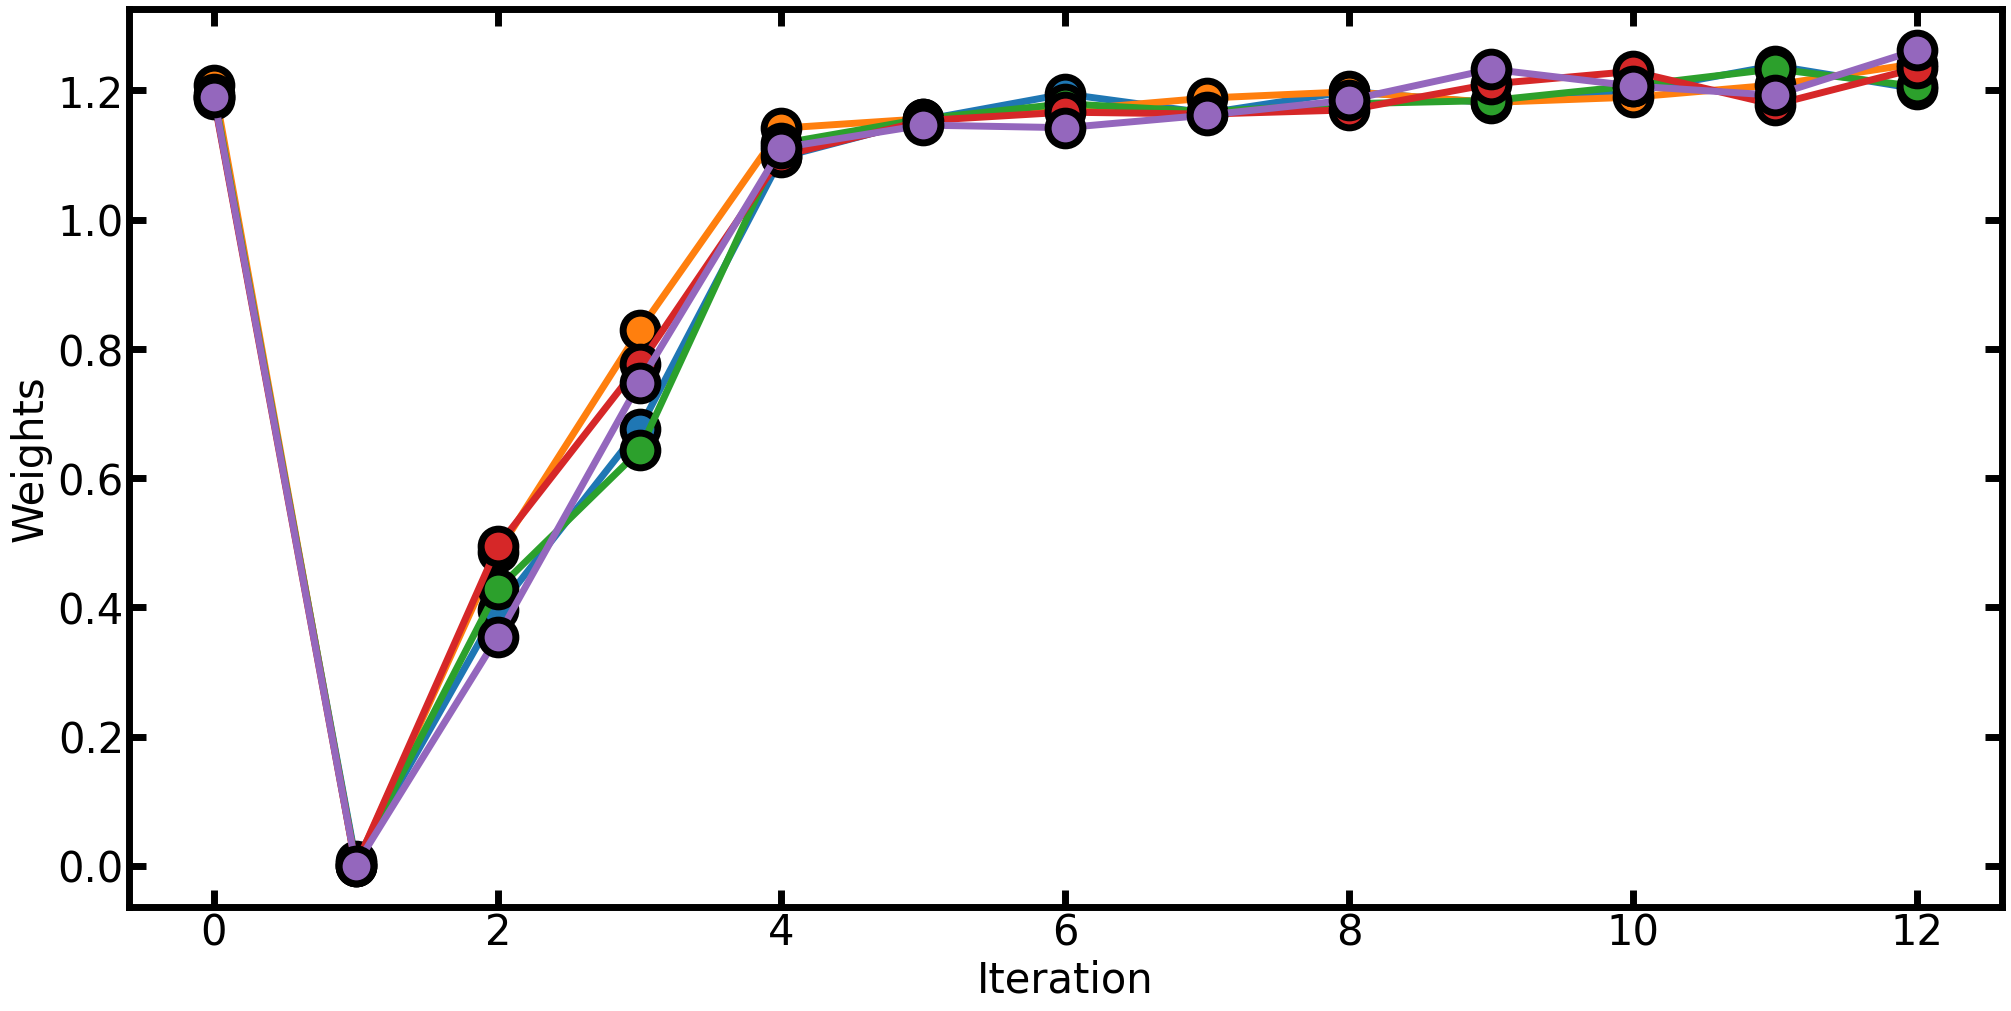

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from mlacs.utilities.plots import init_rcParams

weight = np.loadtxt('MLIP/MLIP.weight')[2:]
weight = weight * len(weight) / np.sum(weight)
nstep = int(len(weight)/5)
x = np.arange(nstep)

fig = plt.figure(figsize=(20, 10), constrained_layout=True)
init_rcParams()
ax0 = fig.add_subplot()
ax0.set_xlabel("Iteration")
ax0.set_ylabel("Weights")
for w in weight.reshape(nstep, 5).T:
    ax0.plot(x, w, marker='o')
plt.show()

You can also notice the very low RMSE and MAE at the end of the MLACS simulation, this is due to reweighting.
As an example, we can fit un new SNAP without the reweighting to compare the results.

In [12]:
mlip_uni = LinearPotential(descriptor)
dyn = OtfMlacs(at,
               states,
               calc,
               mlip_uni,
               prefix_output='Uniform_Trajectory',
               neq=0)
dyn.run(15)

    On-the-fly Machine-Learning Assisted Canonical Sampling
======================= version  0.0.13 =====================
date: 15-02-2024  17:44:29


State 1/5 :
NPT dynamics as implemented in LAMMPS
Temperature (in Kelvin)                 5000
A Langevin thermostat is used
Pressure (GPa)                          10
Number of MLMD equilibration steps :    100
Number of MLMD production steps :       500
Timestep (in fs) :                      1.5
Themostat damping parameter (in fs) :   $(100*dt)
Barostat damping parameter (in fs) :    $(1000*dt)

State 2/5 :
NPT dynamics as implemented in LAMMPS
Temperature (in Kelvin)                 5000
A Langevin thermostat is used
Pressure (GPa)                          10
Number of MLMD equilibration steps :    100
Number of MLMD production steps :       500
Timestep (in fs) :                      1.5
Themostat damping parameter (in fs) :   $(100*dt)
Barostat damping parameter (in fs) :    $(1000*dt)

State 3/5 :
NPT dynamics as implemented in LA

State 5/5 has been launched
Computing energy with the True potential

Computing the average volume
Average structure:
- cell:   15.681046040796163 angs
- vol/atom:   15.209139835262583 angs^3

Computing the average volume
Average structure:
- cell:   15.745995936900044 angs
- vol/atom:   15.407872582562359 angs^3

Computing the average volume
Average structure:
- cell:   15.703776716443707 angs
- vol/atom:   15.279759242548140 angs^3

Computing the average volume
Average structure:
- cell:   15.681500738785420 angs
- vol/atom:   15.210836034348617 angs^3

Computing the average volume
Average structure:
- cell:   15.752252429986868 angs
- vol/atom:   15.429576075827686 angs^3

Step 5

Production step for state 1, configuration 5 for this state
Production step for state 2, configuration 5 for this state
Production step for state 3, configuration 5 for this state
Production step for state 4, configuration 5 for this state
Production step for state 5, configuration 5 for this state


Train

Production step for state 4, configuration 10 for this state
Production step for state 5, configuration 10 for this state


Training new MLIP


Number of configurations for training: 47
Number of atomic environments for training: 11985
RMSE Energy    0.0064 eV/at
MAE Energy     0.0051 eV/at
RMSE Forces    0.3414 eV/angs
MAE Forces     0.2500 eV/angs
RMSE Stress    0.3338 GPa
MAE Stress     0.2519 GPa


Running MLMD
State 1/5 has been launched
State 2/5 has been launched
State 3/5 has been launched
State 4/5 has been launched
State 5/5 has been launched
Computing energy with the True potential

Computing the average volume
Average structure:
- cell:   15.862399851166366 angs
- vol/atom:   15.698131100232070 angs^3

Computing the average volume
Average structure:
- cell:   15.874412340070899 angs
- vol/atom:   15.736525725265590 angs^3

Computing the average volume
Average structure:
- cell:   15.844555968203316 angs
- vol/atom:   15.644829210022165 angs^3

Computing the average volume
A